<a href="https://colab.research.google.com/github/vaishnavi-kedar/demo1/blob/main/Interactive_Headline_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================================
# 📌 Headline Generation using LSTM Variants
# ===============================================

# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Layer, Concatenate, GlobalAveragePooling1D, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# ===============================================
# STEP 2: Load Dataset with Error Handling for Malformed Rows
# ===============================================
try:
    df1 = pd.read_csv('/content/news_summary.csv', encoding='ISO-8859-1', on_bad_lines='skip')[['text', 'headlines']]
    df2 = pd.read_csv('/content/news_summary_more.csv', encoding='ISO-8859-1', engine='python', on_bad_lines='skip')[['text', 'headlines']]
    df = pd.concat([df1, df2]).dropna().reset_index(drop=True)
    if df.empty:
        raise ValueError("The dataset is empty after loading.")
    print(f"Dataset loaded successfully with {len(df)} records.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# ===============================================
# STEP 3: Clean Text
# ===============================================
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

df['clean_text'] = df['text'].apply(clean_text)
df['clean_headlines'] = df['headlines'].apply(clean_text)

# ===============================================
# STEP 4: Tokenization and Padding
# ===============================================
VOCAB_SIZE = 8000
MAX_INPUT_LEN = 50
MAX_TARGET_LEN = 12

input_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
input_tokenizer.fit_on_texts(df['clean_text'])
input_seq = input_tokenizer.texts_to_sequences(df['clean_text'])
input_seq = pad_sequences(input_seq, maxlen=MAX_INPUT_LEN, padding='post')

target_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
target_tokenizer.fit_on_texts(df['clean_headlines'])
target_seq = target_tokenizer.texts_to_sequences(df['clean_headlines'])
target_seq = pad_sequences(target_seq, maxlen=MAX_TARGET_LEN, padding='post')

decoder_input_seq = target_seq[:, :-1]
decoder_target_seq = target_seq[:, 1:]
decoder_target_seq = np.expand_dims(decoder_target_seq, -1)

X_train, X_val, Xd_train, Xd_val, Y_train, Y_val = train_test_split(
    input_seq, decoder_input_seq, decoder_target_seq, test_size=0.1, random_state=42
)

# ===============================================
# STEP 5A: Vanilla LSTM Encoder-Decoder
# ===============================================
def build_lstm_model():
    encoder_inputs = Input(shape=(MAX_INPUT_LEN,))
    enc_emb = Embedding(VOCAB_SIZE, 128)(encoder_inputs)
    enc_out, state_h, state_c = LSTM(128, return_state=True)(enc_emb)

    decoder_inputs = Input(shape=(MAX_TARGET_LEN - 1,))
    dec_emb = Embedding(VOCAB_SIZE, 128)(decoder_inputs)
    dec_lstm, _, _ = LSTM(128, return_sequences=True, return_state=True)(dec_emb, initial_state=[state_h, state_c])

    output = Dense(VOCAB_SIZE, activation='softmax')(dec_lstm)
    model = Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model

# ===============================================
# STEP 5B: LSTM with Bahdanau Attention (Fixed)
# ===============================================
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        query = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def build_attention_model():
    encoder_inputs = Input(shape=(MAX_INPUT_LEN,))
    enc_emb = Embedding(VOCAB_SIZE, 128)(encoder_inputs)
    enc_out, state_h, state_c = LSTM(128, return_sequences=True, return_state=True)(enc_emb)

    decoder_inputs = Input(shape=(MAX_TARGET_LEN - 1,))
    dec_emb = Embedding(VOCAB_SIZE, 128)(decoder_inputs)
    dec_lstm_out, _, _ = LSTM(128, return_sequences=True, return_state=True)(dec_emb, initial_state=[state_h, state_c])

    attention = BahdanauAttention(128)
    context_vector, _ = attention(state_h, enc_out)
    repeated_context = RepeatVector(MAX_TARGET_LEN - 1)(context_vector)
    concat = Concatenate(axis=-1)([dec_lstm_out, repeated_context])
    output = Dense(VOCAB_SIZE, activation='softmax')(concat)

    model = Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model

# ===============================================
# STEP 5C: LSTM with Self-Attention (Fixed)
# ===============================================
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wk = Dense(units)
        self.Wv = Dense(units)

    def call(self, x):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        score = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        weights = tf.nn.softmax(score, axis=-1)
        output = tf.matmul(weights, v)
        return output

def build_self_attention_model():
    encoder_inputs = Input(shape=(MAX_INPUT_LEN,))
    enc_emb = Embedding(VOCAB_SIZE, 128)(encoder_inputs)
    enc_out, state_h, state_c = LSTM(128, return_sequences=True, return_state=True)(enc_emb)

    encoder_sa = SelfAttention(128)(enc_out)
    encoder_pooled = GlobalAveragePooling1D()(encoder_sa)
    encoder_repeated = RepeatVector(MAX_TARGET_LEN - 1)(encoder_pooled)

    decoder_inputs = Input(shape=(MAX_TARGET_LEN - 1,))
    dec_emb = Embedding(VOCAB_SIZE, 128)(decoder_inputs)
    dec_lstm_out, _, _ = LSTM(128, return_sequences=True, return_state=True)(dec_emb, initial_state=[state_h, state_c])

    concat = Concatenate(axis=-1)([dec_lstm_out, encoder_repeated])
    output = Dense(VOCAB_SIZE, activation='softmax')(concat)

    model = Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model

# ===============================================
# STEP 6: Train Self-Attention Model (Example)
# ===============================================
model = build_attention_model()
model.summary()
history = model.fit([X_train, Xd_train], Y_train, validation_data=([X_val, Xd_val], Y_val), batch_size=64, epochs=15)

# ===============================================
# STEP 7: Inference Function
# ===============================================
def generate_headline(input_text, model, input_tokenizer, target_tokenizer):
    input_seq = input_tokenizer.texts_to_sequences([clean_text(input_text)])
    input_seq = pad_sequences(input_seq, maxlen=MAX_INPUT_LEN, padding='post')

    decoder_input = np.zeros((1, MAX_TARGET_LEN - 1))
    decoded_words = []

    for i in range(MAX_TARGET_LEN - 1):
        prediction = model.predict([input_seq, decoder_input], verbose=0)
        sampled_token_index = np.argmax(prediction[0, i, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, '')
        if sampled_word == '':
            break
        decoded_words.append(sampled_word)
        decoder_input[0, i] = sampled_token_index

    return ' '.join(decoded_words)

# ✅ Example usage
print(generate_headline("NASA has launched a new satellite for Earth observation purposes.", model, input_tokenizer, target_tokenizer))


Dataset loaded successfully with 102915 records.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 50, 128)   │  1,024,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 50, 128), │    131,584 │ embedding_4[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 11, 128)   │  1,024,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ [(None, 128),     │     33,153 │ lstm_4[0][1],     │
│ (BahdanauAttention) │ (None, 50, 1)]    │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 11, 128), │    131,584 │ embedding_5[0][0… │
│                     │ (None, 128),      │            │ lstm_4[0][1],     │
│                     │ (None, 128)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 11, 128)   │          0 │ bahdanau_attenti… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 11, 256)   │          0 │ lstm_5[0][0],     │
│ (Concatenate)       │                   │            │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 11, 8000)  │  2,056,000 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,400,321 (16.79 MB)

 Trainable params: 4,400,321 (16.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - loss: 5.7232 - val_loss: 4.8841
Epoch 2/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 4.7048 - val_loss: 4.3640
Epoch 3/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 4.1676 - val_loss: 4.0517
Epoch 4/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - loss: 3.7980 - val_loss: 3.8601
Epoch 5/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 3.5355 - val_loss: 3.7338
Epoch 6/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 3.3040 - val_loss: 3.6458
Epoch 7/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 3.1119 - val_loss: 3.5945
Epoch 8/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 2.9340 - val_loss: 3.5670
Epoch 9/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 2.7839 - val_loss: 3.5541
Epoch 10/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 2.6472 - val_loss: 3.5556
Epoch 11/15
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - loss: 2.5189 - val_loss: 3.5714
Epoch 12

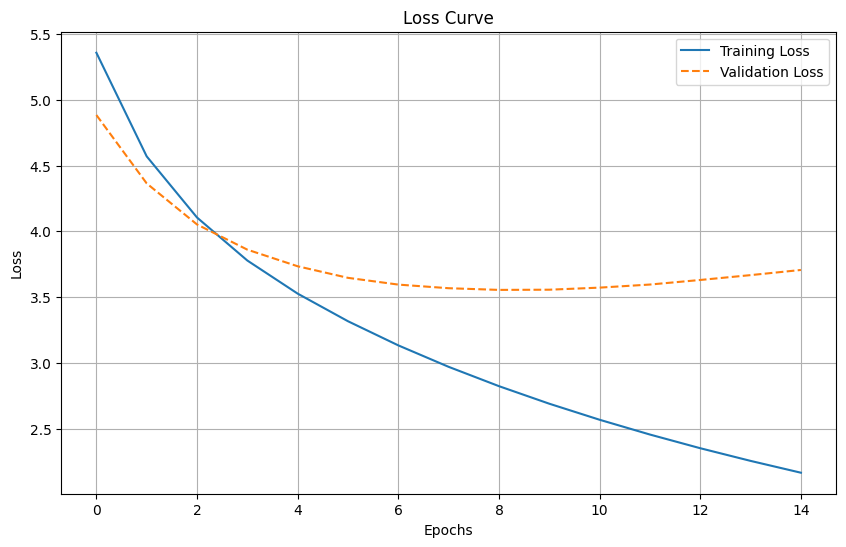

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ===============================================
# ✅ STEP 8: Interactive Headline Generation via User Input
# ===============================================

while True:
    user_input = input("\n📥 Enter a news article (or type 'exit' to stop):\n")
    if user_input.lower() == 'exit':
        print("👋 Exiting headline generator.")
        break
    headline = generate_headline(user_input, model, input_tokenizer, target_tokenizer)
    print(f"\n📰 Generated Headline: {headline}")



📥 Enter a news article (or type 'exit' to stop):
New Zealand defeated India by 8 wickets in the fourth ODI

📰 Generated Headline: 

📥 Enter a news article (or type 'exit' to stop):
exit
👋 Exiting headline generator.
